<a href="https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/train_data_augmentation_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
<td vertical-align="bottom">
<a target="_blank" align="center" href="https://stepup.ai/train_data_augmentation_keras"><img height="32px" src="https://stepup.ai/favicon.png"/>Follow on stepup.ai</a>
</td>
<td>
 <a  target="_blank" href="https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/train_data_augmentation_keras.ipynb"><img style="margin-bottom:10px" src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/train_data_augmentation_keras.ipynb"><img style="margin-bottom:10px" class="invertable-logo" src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"/>View source on GitHub</a>
</td>
<td>
<a href="https://drive.google.com/file/d/1-PBQVVUWhyQ_ctZFqMH02XihvmHOCjIe/view?usp=sharing" download><img class="invertable-logo" style="margin-bottom:10px" src="https://www.tensorflow.org/images/download_logo_32px.png"/>Download notebook</a>
</td>
</table>

# Training with Data Augmentation in Keras
In this tutorial, we are going to train a Cifar10 classifier from scratch and see how much benefit data augmentation can bring.
Follow along on the [blog post](https://stepup.ai/training_data_augmentation_keras) for descriptions and a detailed discussion!

# Setup

## Imports and Helper Functions
First we define the imports for tensorflow, keras and matplotlib.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

And we're going to define a helper function to plot the first few images in a dataset.

In [ ]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

## Load and Cifar10 Dataset
Now let's import the Cifar10 dataset and plot a few images along with their classes.

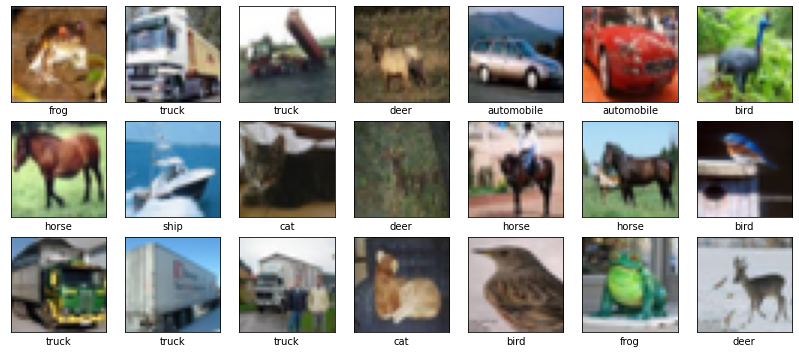

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

# Classifier Training

## Define the Model
We are going to create a function that creates a VGG style convolutional neural network classifier.

In [ ]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Train without Data Augmentation
First we define the basic parameters for model training, such as batch size and number of epochs.
Then we instantiate the model and show the summary. Finally we train it with the unaugmented Cifar10 dataset.

In [ ]:
batch_size = 32
epochs = 16
m_no_aug = create_model()
m_no_aug.summary()

history_no_aug = m_no_aug.fit(
    x_train, y_train,
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, y_test))

loss_no_aug, acc_no_aug = m_no_aug.evaluate(x_test,  y_test)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 8, 8, 128)       

## Define Data Augmentation
Now it's time to set up our data augmentation pipeline.
First we define the augmentation parameters and then we instantiate the data generator.
We also plot a few augmented images to make sure that everything is ok

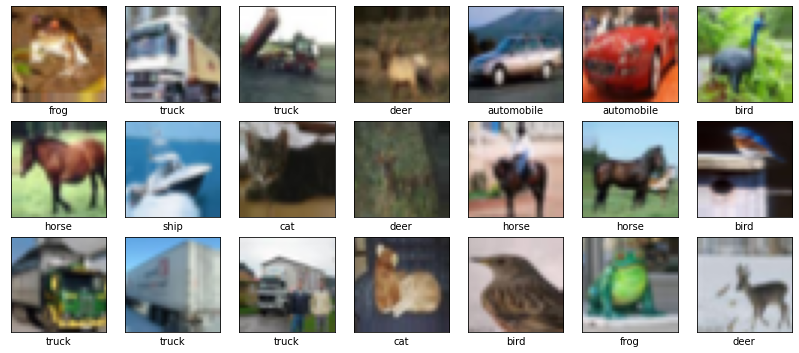

In [ ]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

## Train with Data Augmentation
Let's perform the training again, this time with data augmentation!

In [ ]:
m_aug = create_model()
datagen.fit(x_train)

history_aug = m_aug.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test))
loss_aug, acc_aug = m_aug.evaluate(x_test,  y_test)

Epoch 1/16
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5854 - accuracy: 0.4175 - val_loss: 1.1812 - val_accuracy: 0.5722
Epoch 2/16
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1157 - accuracy: 0.6013 - val_loss: 0.9885 - val_accuracy: 0.6498
Epoch 3/16
1563/1563 [==============================] - 27s 17ms/step - loss: 0.9242 - accuracy: 0.6753 - val_loss: 0.8158 - val_accuracy: 0.7149
Epoch 4/16
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8153 - accuracy: 0.7125 - val_loss: 0.8012 - val_accuracy: 0.7253
Epoch 5/16
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7540 - accuracy: 0.7373 - val_loss: 0.7323 - val_accuracy: 0.7531
Epoch 6/16
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7011 - accuracy: 0.7574 - val_loss: 0.7121 - val_accuracy: 0.7560
Epoch 7/16
1563/1563 [==============================] - 27s 17ms/step - loss: 0.6647 - accuracy: 0.7700 - val_loss: 0.7277 -

# Results
Let's compare the two runs in a single graph:

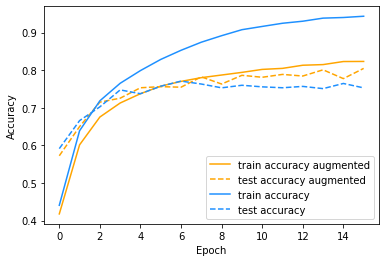

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(history_no_aug.history['accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(history_no_aug.history['val_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

And lets also have a look at the loss curves:

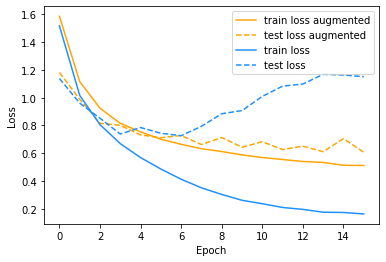

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['loss'],
         label='train loss augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_loss'],
         label='test loss augmented',
         c='orange',ls='--')

plt.plot(history_no_aug.history['loss'],
         label='train loss',
         c='dodgerblue', ls='-')
plt.plot(history_no_aug.history['val_loss'],
         label='test loss',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Head over to the [blog post](https://stepup.ai/train_data_augmentation_keras) for a detailed discussion!